In [5]:
from llm_base import LLM
from extract_page_content import extract_page_content

llm = LLM(
    model="llama-3.1-8b-instant",
    api_key_env="GROQ_API_KEY",
    endpoint="https://api.groq.com/openai/v1/chat/completions"
)


base_prompt = """
Classify the sentence to be classified as 'fake', 'real', or 'unrelated' based solely on the information from the article below:

Article Title: >>> "{}". <<< End of Article Title.
Article Content to be used as source of the information: >>> "{}". <<< End of Article Content.

Answer 'fake' if the article content contradicts the sentence to be classified.
Answer 'real' if the article content supports the sentence to be classified.
Answer 'unrelated' if the article does not address the topic of the sentence to be classified.
Respond with a single word only, without justification.

Sentence to be classified: >>> "{}". <<< End of the sentence.
"""


def judge_content_based(docs):
    for doc in docs:
        try:
            url = doc['link']
            sentence = doc['search_title']
            page_content = extract_page_content(url)
            prompt = base_prompt.format(
                page_content['newspaper_title'],
                page_content['trafilatura_text'],
                sentence,
            )
            response = llm.generate(prompt=prompt, temperature=0.1)
            ret = response.strip().lower()
            if ret == 'unrelated': continue
            return ret 
        except Exception as e:
            print(e)
    return '-'

In [ ]:
import pandas as pd
import numpy as np
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine
from importlib import reload
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

USER = os.getenv("POSTGRES_USER")
PASSWORD = os.getenv("POSTGRES_PASSWORD")
DB = os.getenv("POSTGRES_DB")
PORT = os.getenv("POSTGRES_PORT")
HOST = os.getenv("POSTGRES_HOST", "localhost")

# Criar engine SQLAlchemy
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

df_com_rag = pd.read_sql(f"SELECT * FROM teste_ner_ddgo_results", engine)
df_sem_rag = pd.read_sql("SELECT * FROM test3_results", engine)
df = df_sem_rag.drop(['id'], axis=1).merge(df_com_rag.drop(['id'], axis=1), on=['search_title', 'shuffle_id', 'true_class'], suffixes=('_sem_rag', '_com_rag'))
df['response'] = df.apply(lambda x: x['response_sem_rag'] if x['response_sem_rag'] == x['response_com_rag'] else 'DIVERGE', axis=1)
df_sem_match = df[df['response'] == 'DIVERGE']
df_com_match = df[df['response'] != 'DIVERGE']
df_com_match

,search_title,shuffle_id,response_sem_rag,true_class,response_com_rag,response
1,DOZENS Of GOP Foreign Policy Experts Pledge T...,1,fake,fake,fake,fake
2,REPORT: Trump Laughed After Woman Was Grabbed...,2,fake,fake,fake,fake
4,"Flash floods kill five in Malaysia, army deplo...",4,real,real,real,real
5,SLICK SCAM: John Kerry Warns Global Warming Wi...,5,fake,fake,fake,fake
6,These Panties Let You Protest Anti-Choice Rep...,6,fake,fake,fake,fake
...,...,...,...,...,...,...
1995,Conservative Texas Lt. Governor Tweets Vile B...,573,real,fake,real,real
1996,HILLARY THROWS HER WEALTH AND STATUS Into The ...,594,fake,fake,fake,fake
1997,TOLD TO SURRENDER: Former Trump Campaign Manag...,609,fake,fake,fake,fake
1998,Trump BEGGED This Singer To Perform At His In...,623,fake,fake,fake,fake


Text(0.5, 36.72222222222221, 'LLM Output')

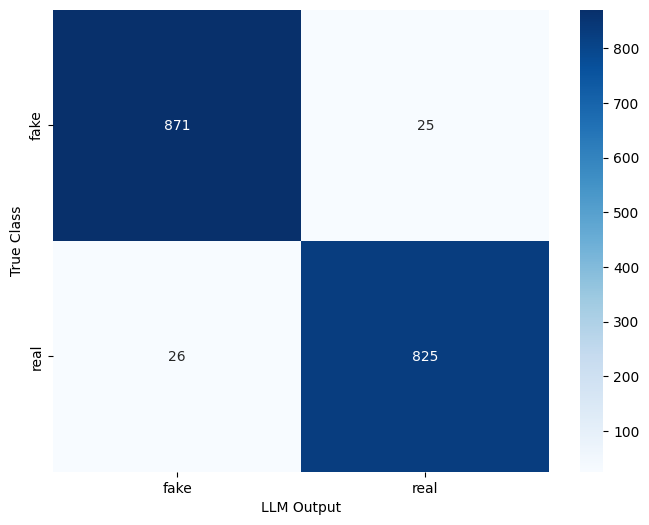

In [7]:
y_true = df_com_match['true_class']
y_pred = df_com_match['response']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df_com_match = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df_com_match, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

In [ ]:
import json
with open(r"resultados_link.json", "r", encoding="utf-8") as f:
    filtered_by_title = json.load(f)
df_sem_match = df_sem_match.drop('response', axis=1)
df_sem_match['docs'] = df_sem_match['search_title'].apply(lambda x: filtered_by_title[x])
df_sem_match

,search_title,shuffle_id,response_sem_rag,true_class,response_com_rag,docs
0,Supreme Court Justice Ginsburg 'regrets' Trump...,0,fake,real,real,[{'refined_title': 'Supreme Court Justice Gins...
3,"In North Dakota, Trump finds Democrat willing ...",3,fake,real,real,[{'refined_title': 'Trump to visit North Dakot...
21,Democrats Raise Money To Rebuild Firebombed G...,21,fake,fake,real,[{'refined_title': 'Democrats Show Crucial Sig...
23,Russian presidential hopeful says she won't sl...,23,fake,real,real,[{'refined_title': '2024 Russian presidential ...
26,PLANNED PARENTHOOD Draws Outrage After Mother’...,26,real,fake,fake,[{'refined_title': 'PLANNED PARENTHOOD Draws O...
...,...,...,...,...,...,...
1979,"Trump on Twitter (Feb 8) - Immigration, Sherif...",263,fake,real,real,[{'refined_title': 'Here's How Trump Honored A...
1982,White House says committed to implementing Ira...,325,fake,real,real,[{'refined_title': 'Paris Agreement - Wikipedi...
1985,Exasperated Anderson Cooper Tells Trump Suppo...,415,fake,fake,real,[{'refined_title': 'Anderson Cooper tells MAGA...
1988,"Democrats link guns to terrorism, turn to gun ...",444,fake,real,real,[{'refined_title': 'Democrats link guns to ter...


In [9]:
df_sem_match['response'] = df_sem_match['docs'].apply(judge_content_based)
df_sem_match

Article `download()` failed with HTTPSConnectionPool(host='www.dailymail.co.uk', port=443): Read timed out. (read timeout=2) on URL https://www.dailymail.co.uk/news/article-4845442/Trump-North-Dakota-search-votes-tax-reform.html
Article `download()` failed with HTTPSConnectionPool(host='www.nodakoutdoors.com', port=443): Read timed out. (read timeout=2) on URL https://www.nodakoutdoors.com/threads/the-tax-plan.176425/
Article `download()` failed with HTTPSConnectionPool(host='www.nodakoutdoors.com', port=443): Read timed out. (read timeout=2) on URL https://www.nodakoutdoors.com/threads/thank-you-democrats.181731/
Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2016/dec/12/donald-trump-promises-resolve-dakota-access-pipeli/ on URL https://www.washingtontimes.com/news/2016/dec/12/donald-trump-promises-resolve-dakota-access-pipeli/
Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/9

,search_title,shuffle_id,response_sem_rag,true_class,response_com_rag,docs,response
0,Supreme Court Justice Ginsburg 'regrets' Trump...,0,fake,real,real,[{'refined_title': 'Supreme Court Justice Gins...,real
3,"In North Dakota, Trump finds Democrat willing ...",3,fake,real,real,[{'refined_title': 'Trump to visit North Dakot...,-
21,Democrats Raise Money To Rebuild Firebombed G...,21,fake,fake,real,[{'refined_title': 'Democrats Show Crucial Sig...,fake
23,Russian presidential hopeful says she won't sl...,23,fake,real,real,[{'refined_title': '2024 Russian presidential ...,real
26,PLANNED PARENTHOOD Draws Outrage After Mother’...,26,real,fake,fake,[{'refined_title': 'PLANNED PARENTHOOD Draws O...,real
...,...,...,...,...,...,...,...
1979,"Trump on Twitter (Feb 8) - Immigration, Sherif...",263,fake,real,real,[{'refined_title': 'Here's How Trump Honored A...,-
1982,White House says committed to implementing Ira...,325,fake,real,real,[{'refined_title': 'Paris Agreement - Wikipedi...,fake
1985,Exasperated Anderson Cooper Tells Trump Suppo...,415,fake,fake,real,[{'refined_title': 'Anderson Cooper tells MAGA...,real
1988,"Democrats link guns to terrorism, turn to gun ...",444,fake,real,real,[{'refined_title': 'Democrats link guns to ter...,real


Text(0.5, 36.72222222222221, 'LLM Output')

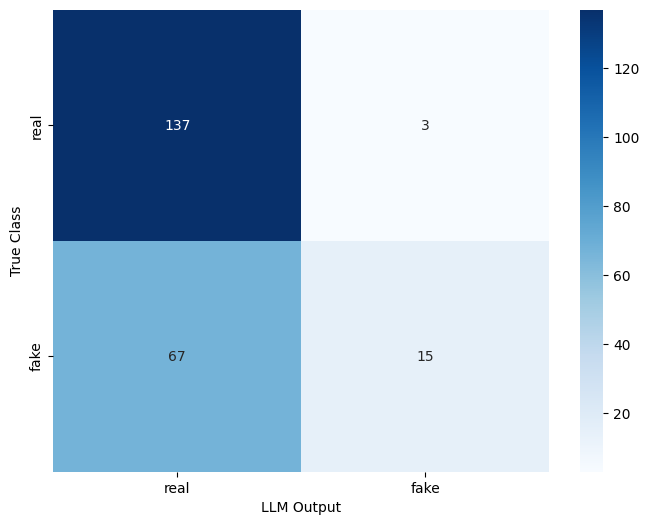

In [ ]:
y_true = df_sem_match['true_class']
y_pred = df_sem_match['response']

cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df_sem_match = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df_sem_match, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

Text(0.5, 36.72222222222221, 'LLM Output')

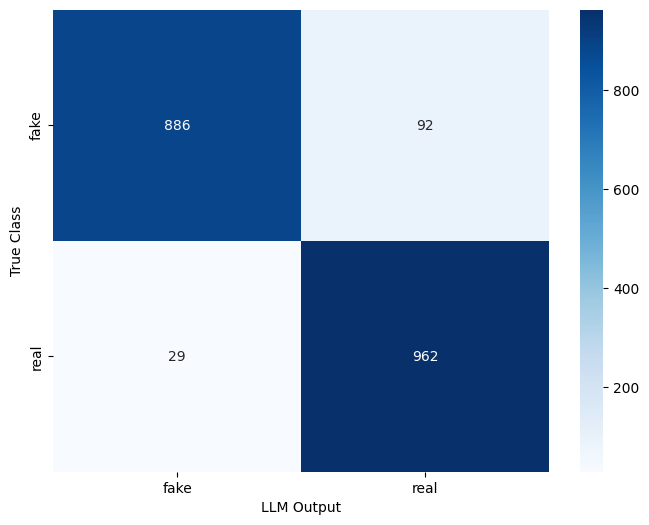

In [11]:
df_final = pd.concat([df_com_match, df_sem_match])

y_true = df_final['true_class']
y_pred = df_final['response']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df_final = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df_final, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

In [12]:
df_sem_match.value_counts('response')

response
real      204
-          29
fake       18
"real"      1
false       1
Name: count, dtype: int64